# Mapping GDELT Events

## Requirements

In [ ]:
!pip install --user arcgis
!pip install --user gdelt

## Import modules

In [1]:
from arcgis.gis import GIS
from arcgis.features import GeoAccessor as geo
from datetime import date
from gdelt import gdelt as gdelt_client
import matplotlib.pyplot as plot
import seaborn

## Getting GDELT events of today
Date must be formatted as a string.

In [2]:
def get_events(date):
    client = gdelt_client(version=2)
    events = client.Search(date.strftime("%Y %m %d"), table="events", coverage=True)
    del client
    return events

def get_today_events():
    return get_events(date.today())

In [3]:
events = get_today_events()
events.describe()

,GLOBALEVENTID,SQLDATE,MonthYear,Year,FractionDate,IsRootEvent,QuadClass,GoldsteinScale,NumMentions,NumSources,...,Actor1Geo_Type,Actor1Geo_Lat,Actor1Geo_Long,Actor2Geo_Type,Actor2Geo_Lat,Actor2Geo_Long,ActionGeo_Type,ActionGeo_Lat,ActionGeo_Long,DATEADDED
count,1.084160e+05,1.084160e+05,108416.000000,108416.000000,108416.000000,108416.000000,108416.00000,108416.000000,108416.000000,108416.000000,...,108416.000000,95162.000000,95171.000000,108416.000000,74520.000000,74524.000000,108416.000000,105429.000000,105434.000000,1.084160e+05
mean,9.412113e+08,2.020073e+07,202007.101913,2019.991071,2020.612342,0.580293,1.76699,0.659217,5.058395,1.066724,...,2.502287,30.074704,1.359797,1.950266,30.377232,3.545816,2.781185,30.004063,0.717391,2.020082e+13
std,4.773691e+04,1.569032e+03,15.691158,0.156913,0.156775,0.493513,1.09711,4.574971,4.816361,0.507485,...,1.527607,21.827497,78.765452,1.702609,21.522220,77.308409,1.349623,21.892468,79.138858,5.671739e+04
min,9.411309e+08,2.010082e+07,201008.000000,2010.000000,2010.630100,0.000000,1.00000,-10.000000,1.000000,1.000000,...,0.000000,-85.622100,-176.533000,0.000000,-85.622100,-176.533000,0.000000,-85.622100,-176.533000,2.020082e+13
25%,9.411692e+08,2.020082e+07,202008.000000,2020.000000,2020.621900,0.000000,1.00000,-2.000000,2.000000,1.000000,...,1.000000,23.116700,-77.036400,0.000000,24.000000,-77.036400,1.000000,22.616300,-77.264000,2.020082e+13
50%,9.412116e+08,2.020082e+07,202008.000000,2020.000000,2020.621900,1.000000,1.00000,1.900000,4.000000,1.000000,...,3.000000,35.641100,8.500000,2.000000,35.641100,12.483300,3.000000,35.641100,8.000000,2.020082e+13
75%,9.412533e+08,2.020082e+07,202008.000000,2020.000000,2020.621900,1.000000,3.00000,3.400000,8.000000,1.000000,...,4.000000,42.237300,51.514800,4.000000,42.237300,51.514800,4.000000,42.237300,51.533300,2.020082e+13
max,9.412918e+08,2.020082e+07,202008.000000,2020.000000,2020.621900,1.000000,4.00000,10.000000,180.000000,17.000000,...,5.000000,81.000000,180.000000,5.000000,81.000000,180.000000,5.000000,81.000000,180.000000,2.020082e+13


## Plot the number of sources
We are using a logarithmic scale for plotting the number of sources.

Text(0,0.5,'Count')

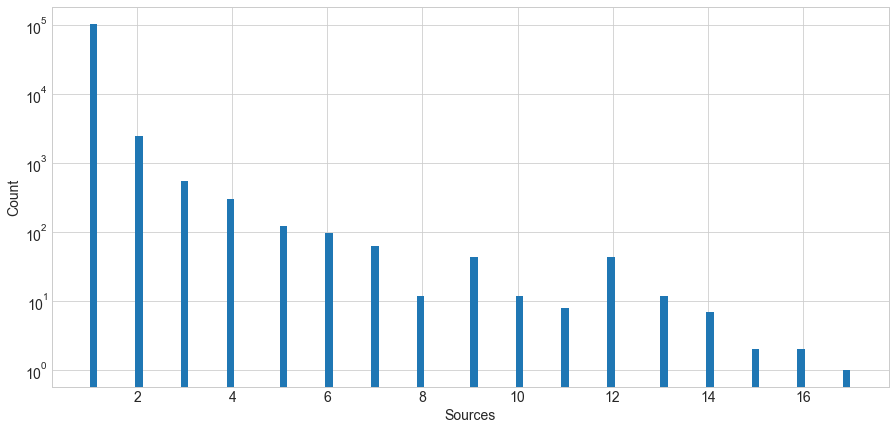

In [5]:
seaborn.set_style("whitegrid")
plot.rcParams["figure.figsize"] = (15, 7)

figure, axis = plot.subplots()
events["NumSources"].hist(ax=axis, bins=100)
axis.set_yscale("log")
axis.tick_params(labelsize=14)
axis.set_xlabel("Sources", fontsize=14)
axis.set_ylabel("Count", fontsize=14)

## Connect to ArcGIS Online anonymously

In [6]:
gis = GIS()

## Display a map of europe
***Hint:*** *map.basemaps shows a list of all available basemaps*

In [7]:
def get_europe_map():
    focus_map = gis.map("Europe")
    focus_map.basemap = "dark-gray-vector"
    return focus_map

focus_map = get_europe_map()

In [8]:
focus_map

MapView(layout=Layout(height='400px', width='100%'))

## Create a spatial dataframe for mapping the events from the pandas dataframe
We are using the ActionGeo_Long and ActionGeo_Lat for locating the events. The spatial reference is WGS84 having EPSG-Code of 4326.
- Extract only the columns relevant for mapping and having a simple type (e.g. int64, float64)
- We are dropping all records having "not a number" for latitude or longitude
- We are slicing and creating a deep copy from the events dataframe

In [9]:
mapping_events = events[["GLOBALEVENTID", 
                         "ActionGeo_FullName", 
                         "ActionGeo_Long", 
                         "ActionGeo_Lat", 
                         "NumMentions", 
                         "SOURCEURL"]].dropna(subset=["ActionGeo_Lat", "ActionGeo_Long"]) 
geo_events = geo.from_xy(mapping_events, x_column="ActionGeo_Long", y_column="ActionGeo_Lat", sr=4326)
geo_events.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105429 entries, 0 to 108415
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   GLOBALEVENTID       105429 non-null  int64   
 1   ActionGeo_FullName  105429 non-null  object  
 2   ActionGeo_Long      105429 non-null  float64 
 3   ActionGeo_Lat       105429 non-null  float64 
 4   NumMentions         105429 non-null  int64   
 5   SOURCEURL           105429 non-null  object  
 6   SHAPE               105429 non-null  geometry
dtypes: float64(2), geometry(1), int64(2), object(2)
memory usage: 6.4+ MB


## Display a subset of GDELT events on the map
- Sort the events by using the number of mentions in all source documents. The number of mentions could be used to determine how important the event is. Multiple references within a single document are counted too.

In [10]:
del focus_map
focus_map = get_europe_map()
top_mapping_events = mapping_events.sort_values(by="NumMentions", ascending=False).head(n=1000)
top_geo_events = geo.from_xy(top_mapping_events, x_column="ActionGeo_Long", y_column="ActionGeo_Lat", sr=4326)
top_geo_events.spatial.plot(map_widget=focus_map)
focus_map

MapView(layout=Layout(height='400px', width='100%'))

## Display the GDELT events using a heatmap
We are creating a new map widget and convert all "mapping events" to a spatial data frame.

In [12]:
del focus_map
heat_focus_map = get_europe_map()
geo_events.spatial.plot(map_widget=heat_focus_map, renderer_type="h")
heat_focus_map

MapView(layout=Layout(height='400px', width='100%'))